In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [29]:
coin="BTC-USD"
df=pd.read_csv("./data/{}.csv".format(coin))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-20,11095.870117,11095.870117,10814.477539,10938.271484,10938.271484,2.469952e+10
1,2020-09-21,10934.925781,10988.304688,10380.260742,10462.259766,10462.259766,2.888500e+10
2,2020-09-22,10459.624023,10568.077148,10382.726563,10538.459961,10538.459961,2.362179e+10
3,2020-09-23,10539.457031,10637.847656,10185.774414,10225.864258,10225.864258,2.298673e+10
4,2020-09-24,10227.479492,10765.794922,10215.205078,10745.548828,10745.548828,2.301754e+10


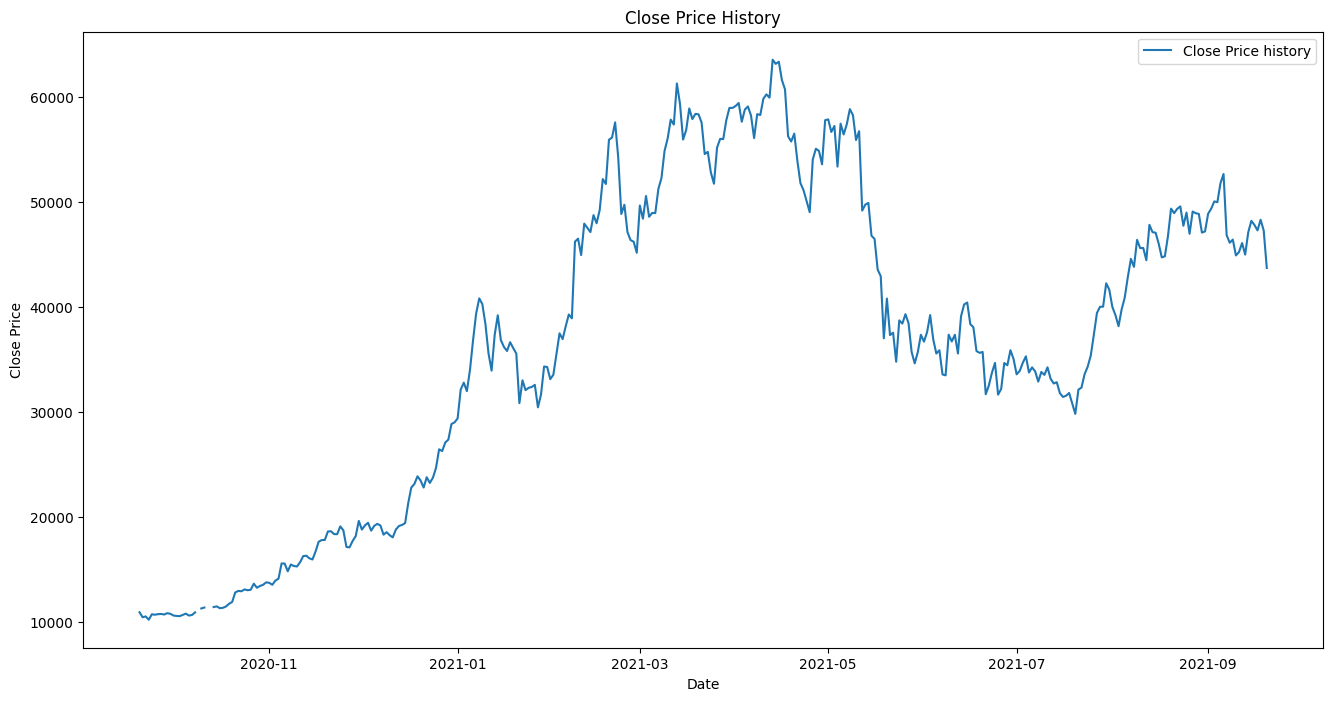

In [30]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize=(16, 8))
plt.plot(df["Close"], label='Close Price history')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price History')
plt.legend()
plt.show()

In [31]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3024\1809871565.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_dataset["Date"][i]=data['Date'][i]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3024\1809871565.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment 

In [32]:
training_ratio=0.8
training_size=int(len(new_dataset)*training_ratio)

In [33]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values
train_data=final_dataset[0:training_size,:]
valid_data=final_dataset[training_size:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]
prediction_days = 60

for i in range(prediction_days,len(train_data)):
    x_train_data.append(scaled_data[i-prediction_days:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

c:\Python312\Lib\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


In [34]:
x_train_data

array([[[0.01337161],
        [0.00443705],
        [0.0058673 ],
        ...,
        [0.12181945],
        [0.13926196],
        [0.14223881]],

       [[0.00443705],
        [0.0058673 ],
        [0.        ],
        ...,
        [0.13926196],
        [0.14223881],
        [0.1424844 ]],

       [[0.0058673 ],
        [0.        ],
        [0.00975428],
        ...,
        [0.14223881],
        [0.1424844 ],
        [0.15757938]],

       ...,

       [[0.88462214],
        [0.91178881],
        [0.90106271],
        ...,
        [0.45877979],
        [0.47040258],
        [0.44146401]],

       [[0.91178881],
        [0.90106271],
        [0.85653143],
        ...,
        [0.47040258],
        [0.44146401],
        [0.45064594]],

       [[0.90106271],
        [0.85653143],
        [0.87238757],
        ...,
        [0.44146401],
        [0.45064594],
        [0.44351598]]])

In [35]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-prediction_days:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


232/232 - 5s - 19ms/step - loss: nan


In [36]:
X_test=[]
for i in range(prediction_days,inputs_data.shape[0]):
    X_test.append(inputs_data[i-prediction_days:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


In [37]:
lstm_model.save("./model/{}.h5".format(coin))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3024\1200164318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


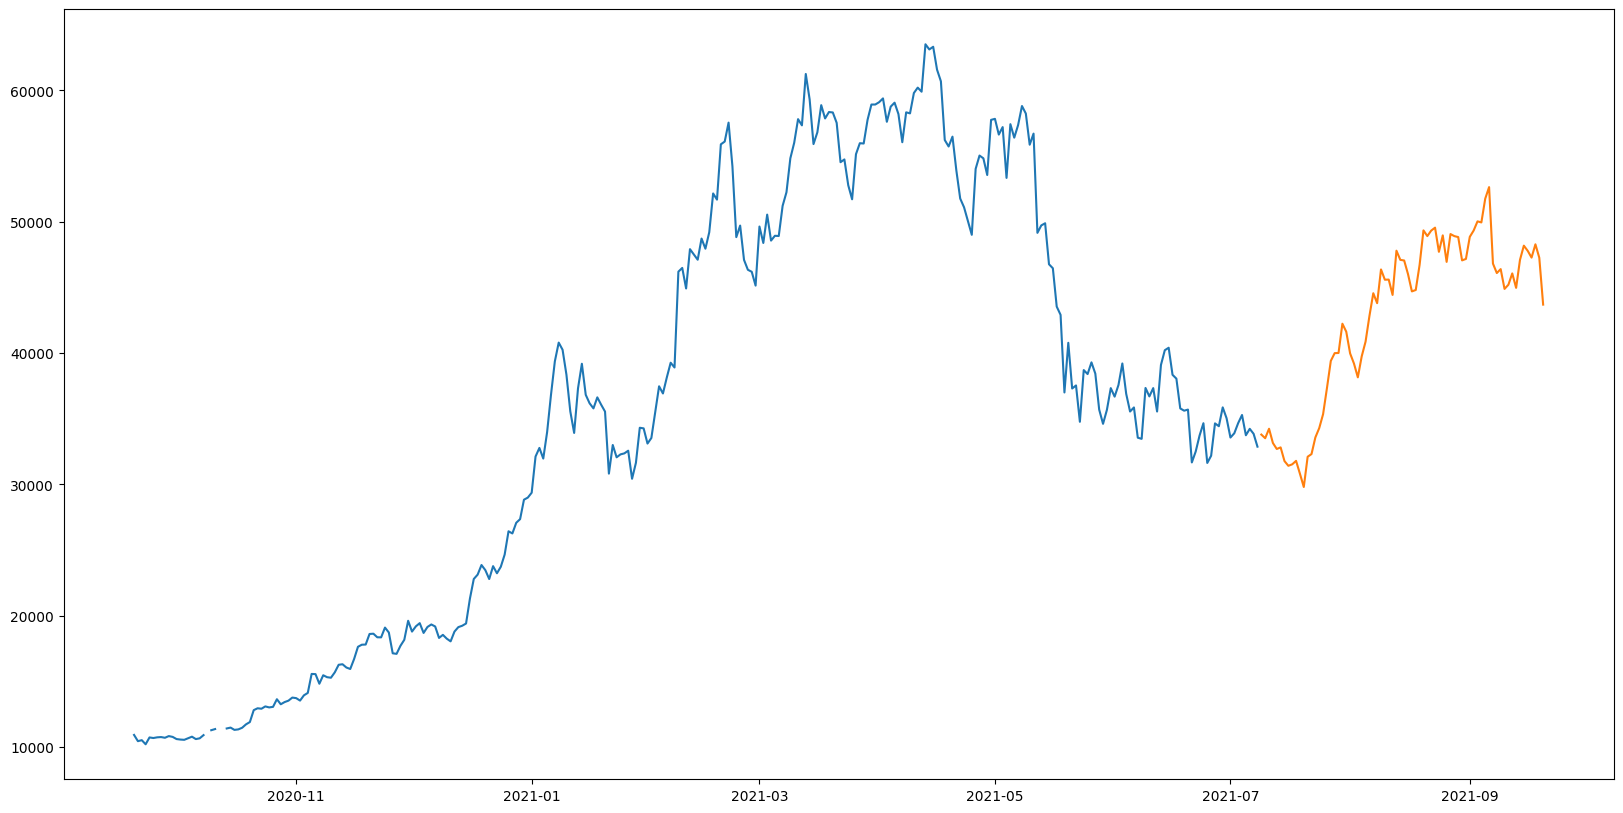

In [38]:
train_data=new_dataset[:training_size]
valid_data=new_dataset[training_size:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])